### Brain image with skull

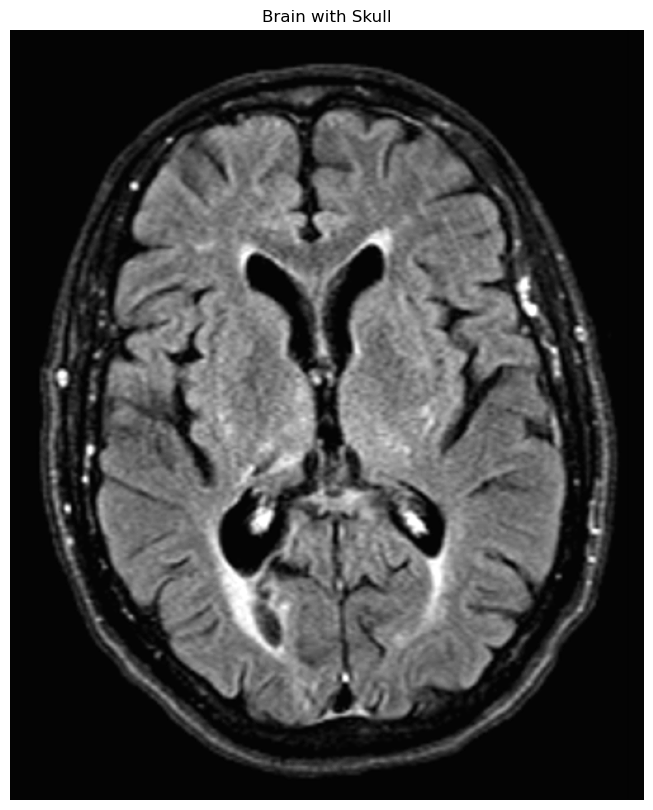

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater 

def ShowImage(title, img, ctype):
    plt.figure(figsize=(10, 10))
    if ctype == 'bgr':
        b, g, r = cv2.split(img)  # get b,g,r
        rgb_img = cv2.merge([r, g, b])  # switch it to rgb
        plt.imshow(rgb_img)
    elif ctype == 'hsv':
        rgb = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        plt.imshow(rgb)
    elif ctype == 'gray':
        plt.imshow(img, cmap='gray')
    elif ctype == 'rgb':
        plt.imshow(img)
    else:
        raise Exception("Unknown colour type")
    plt.axis('off')
    plt.title(title)
    plt.show()

# Read in image
img = cv2.imread(r"C:\Users\shema\Downloads\brain.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ShowImage('Brain with Skull', gray, 'gray')


### Extracting a mask

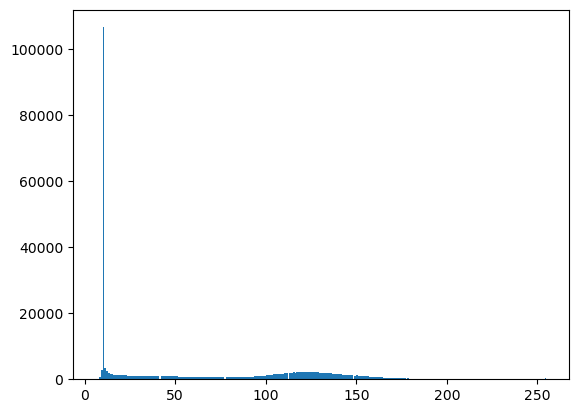

In [2]:
plt.hist(gray.ravel(),256)
plt.show()

### Applying Otsu's method can be used to threshold them into a binary mask

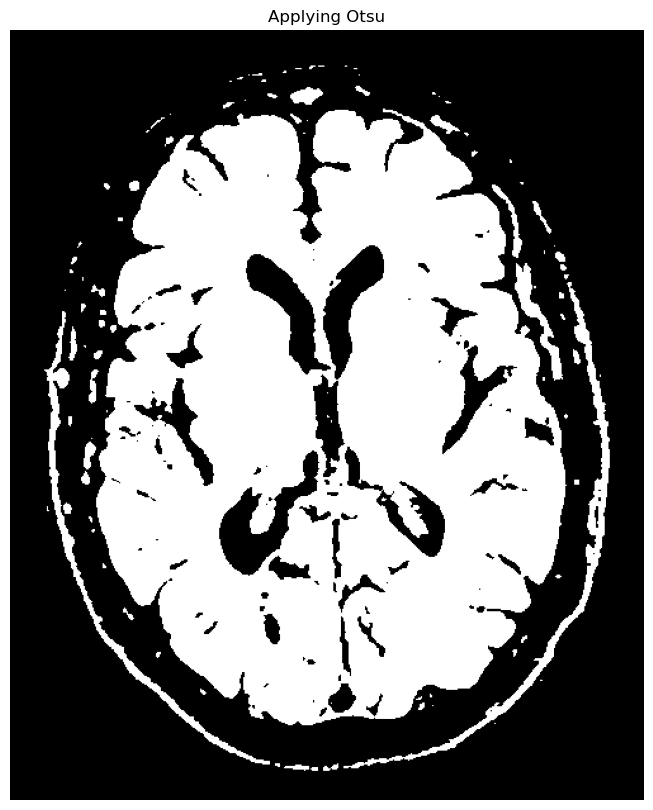

In [3]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Applying Otsu',thresh,'gray')

### Overlaying mask into original image

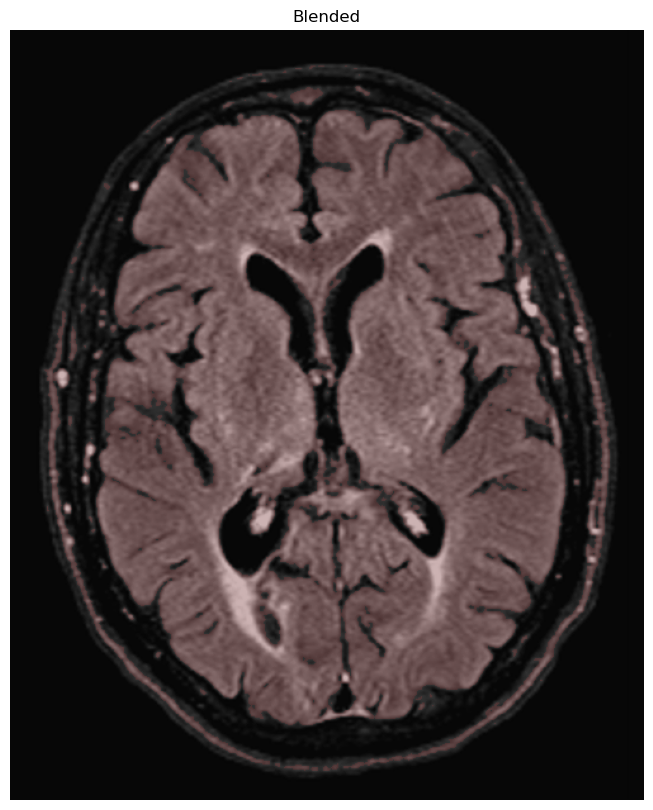

In [4]:
colormask = np.zeros(img.shape, dtype=np.uint8)
colormask[thresh!=0] = np.array((0,0,255))
blended = cv2.addWeighted(img,0.7,colormask,0.1,0)
ShowImage('Blended', blended, 'bgr')

### Extracting the brain

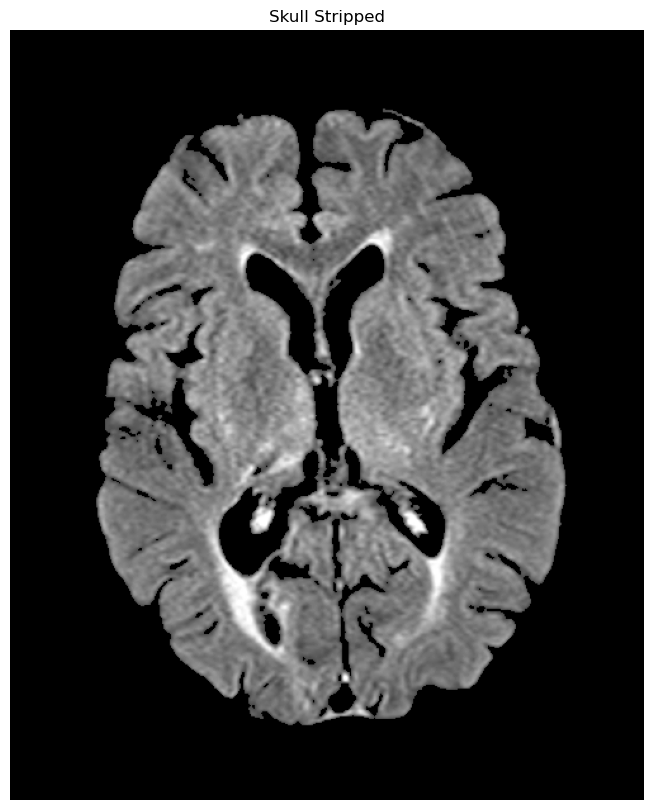

In [5]:
ret, markers = cv2.connectedComponents(thresh)

marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 

# label of largest component by area
largest_component = np.argmax(marker_area)+1

#pixels which correspond to the brain
brain_mask = markers==largest_component

brain_out = img.copy()

# clear pixels that don't correspond to the brain
brain_out[brain_mask==False] = (0,0,0)
ShowImage('Skull Stripped',brain_out,'rgb')

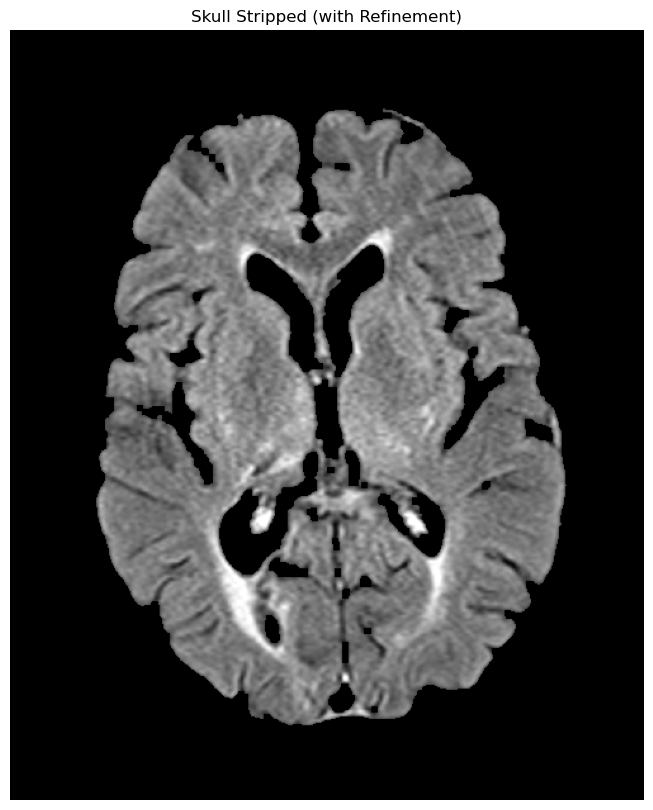

In [6]:
ret, markers = cv2.connectedComponents(thresh)
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0]
largest_component = np.argmax(marker_area) + 1
brain_mask = markers == largest_component

# Use morphological operations (erosion and dilation) to refine the brain mask
kernel = np.ones((5, 5), np.uint8)
brain_mask = cv2.morphologyEx(brain_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

brain_out = img.copy()
brain_out[brain_mask == 0] = (0, 0, 0)

ShowImage('Skull Stripped (with Refinement)', brain_out, 'rgb')

In [7]:
import SimpleITK as sitk

def register_images(fixed_image, moving_image):
    # Find translation vector using OpenCV's phase correlation
    cc = cv2.phaseCorrelate(np.float32(fixed_image), np.float32(moving_image))
    translation_vector = cc[0]

    # Apply translation to moving image using OpenCV's warpAffine
    rows, cols = moving_image.shape
    M = np.float32([[1, 0, translation_vector[0]], [0, 1, translation_vector[1]]])
    registered_image = cv2.warpAffine(moving_image, M, (cols, rows))

    return registered_image.astype(np.uint8) 

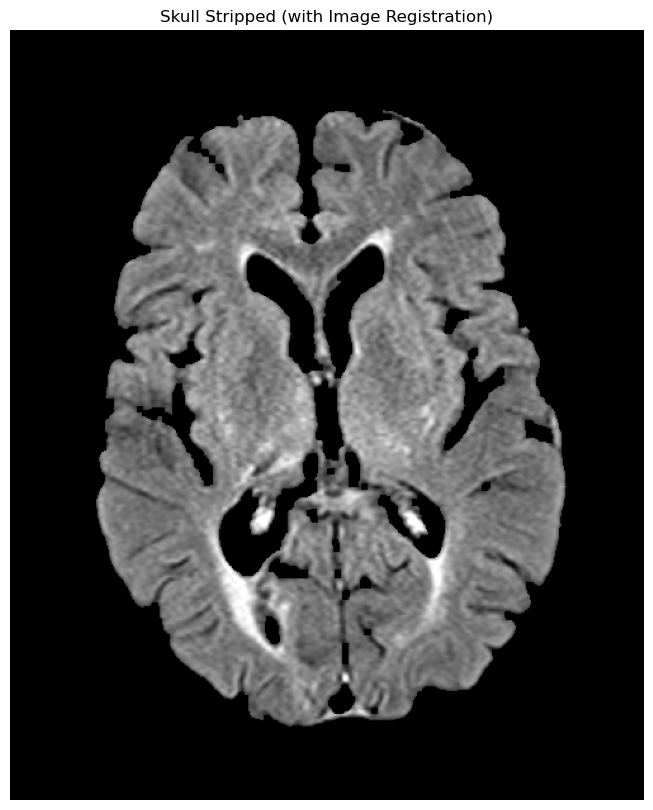

In [8]:
# Retain the existing code for connected components and brain mask creation
ret, markers = cv2.connectedComponents(thresh)
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0]
largest_component = np.argmax(marker_area) + 1
brain_mask = markers == largest_component

# Use morphological operations (erosion and dilation) to refine the brain mask
kernel = np.ones((5, 5), np.uint8)
brain_mask = cv2.morphologyEx(brain_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

# Use image registration to align the brain mask with the original image
registered_brain_mask = register_images(gray, brain_mask)

brain_out = img.copy()
brain_out[registered_brain_mask == 0] = (0, 0, 0)

ShowImage('Skull Stripped (with Image Registration)', brain_out, 'rgb')

Pixel values of the outer boundary:
[ 76  74  93  82  44  82  76 101  81  94  75  75  86  76  63  81  77  88
  74  75 100  85  75  76  93  78  77 101  79  98  77  74  95  77  84  75
  87  81  76  87  75  77  84  76  77  94  78  76  89  91  74  76  88  75
  94  80  95  76 101  78  98  74  90  80 115  76  94 116  91  77 109  88
 122  80 105  74  81  78  91  79  98  74  94  83 100  85 104  74  82  86
  79  91  74  97  76  78  87  80  92  82 107  80  93  78  89  76  83 107
  88 106  87 100  81 103  86  96  75  79  95  79  87  83  93  95  81  80
  76  78  91  73  94  97  85  74  89  76 104  89  99  82  87  74  77  86
  78  77  80  71  82  79  59  86  78  58  51  85  93  54  88  75  71  79
  77  81  70  84  74  74  76  91  75  90  74  86  80  85  77  79  74  90
  89  74  96  79  78 101  74 108  88 106  80 104  89 110  76  96  76 102
  86 100  80  93  75  96  74  94  80 108  94 116  93 106  85 109  74  75
 105  86 101  74  74  86  75  86  75  86  72  86  97  84  90  77  85  77
  95  86  95  7

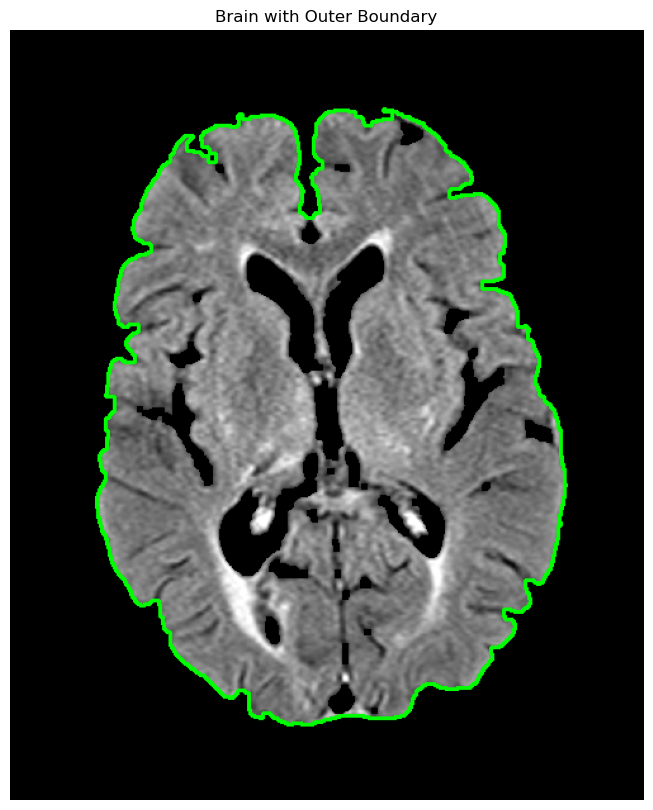

In [9]:
brain_mask = cv2.morphologyEx(brain_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
registered_brain_mask = register_images(gray, brain_mask)
brain_out = img.copy()
brain_out[registered_brain_mask == 0] = (0, 0, 0)

# Find external contours
contours, _ = cv2.findContours(brain_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the outer contour on the original image
outer_contour_image = brain_out.copy()
cv2.drawContours(outer_contour_image, contours, -1, (0, 255, 0), 2)  # Green color for contour

# Get the pixel values of the outer boundary
outer_boundary_coordinates = contours[0].squeeze()
outer_boundary_pixel_values = gray[outer_boundary_coordinates[:, 1], outer_boundary_coordinates[:, 0]]

# Print the pixel values of the outer boundary
print("Pixel values of the outer boundary:")
print(outer_boundary_pixel_values)

# Display the image with the outer boundary
ShowImage('Brain with Outer Boundary', outer_contour_image, 'bgr')

Matrix values (i, j) of the outer boundary:
[[294  62]
 [294  64]
 [300  64]
 ...
 [301  63]
 [296  63]
 [295  62]]


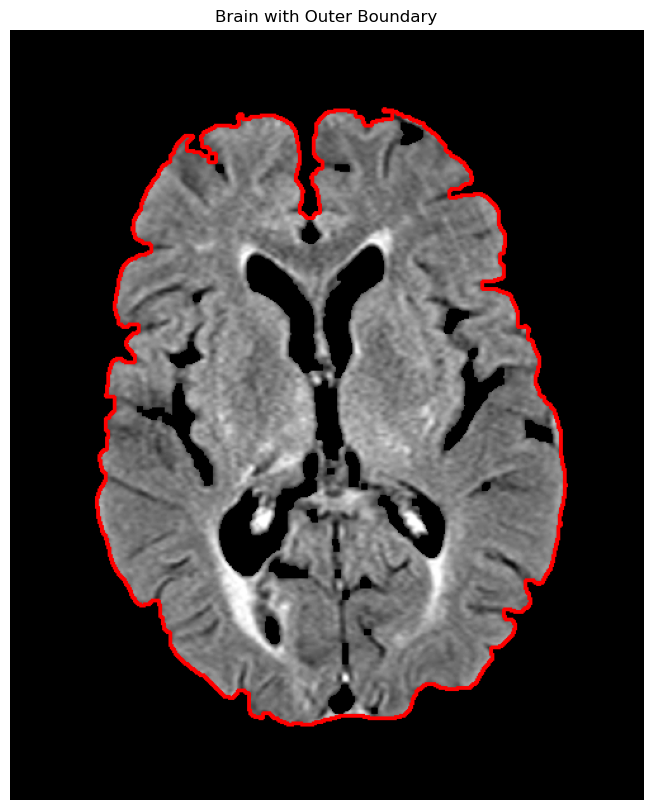

In [10]:
brain_mask = cv2.morphologyEx(brain_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
registered_brain_mask = register_images(gray, brain_mask)
brain_out = img.copy()
brain_out[registered_brain_mask == 0] = (0, 0, 0)

# Find external contours
contours, _ = cv2.findContours(brain_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the coordinates of the outer boundary
outer_boundary_coordinates = contours[0].squeeze()

# Print the matrix values (i, j) of the outer boundary
print("Matrix values (i, j) of the outer boundary:")
print(outer_boundary_coordinates)

# Draw the outer contour on the original image
outer_contour_image = brain_out.copy()
cv2.drawContours(outer_contour_image, contours, -1, (0, 0, 255), 2)  # Green color for contour

# Display the image with the outer boundary
ShowImage('Brain with Outer Boundary', outer_contour_image, 'bgr')